In [1]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit
from poliastro.examples import iss

from scipy.stats import expon, uniform, norm, triang
from scipy.special import comb

from lib.GPUKeplerSimulation import propagate, average_scaler, average_3vector, M_to_E, E_to_nu
from lib.DisplaySimulation import displaySimulation

In [2]:
# Exponential Distribution
size = 100

J_1 = expon.rvs(scale=1, loc=0.0, size=size)

exponential_var2 = expon.rvs(scale=0.01, loc=0, size=size)
J_2 = J_1 - exponential_var2

for i in range(0,size):
    if J_2[i] < 0.0:
        J_2[i] = 0.0001

exponential_var3 = expon.rvs(scale=0.1, loc=0, size=size)
J_3 = J_2 - exponential_var3

for i in range(0,size):
    if J_3[i] < -J_2[i]:
        J_3[i] = -J_2[i]

M = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
w = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
Omega = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad

In [3]:
# Near Circular Distribution
size = 500
r_0 = 1*u.km
sigma_e = 0.01*np.sqrt(1*u.km)
sigma_a = 0.000*np.sqrt(1*u.km)
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=sigma_e, loc=0, size=size)*np.sqrt(1*u.km)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = expvar1 + J_2
J_3 = J_2

M = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [2]:
# Near SHO Distribution
# Here I'm setting J_SHO = sqrt(ma^3/2k) * (p^2/2m + k/a^3*x^2)
# This leads to J_SHO = sqrt(ka/2)e^2 = sqrt(k/2)(J_1 - J_2^2/J_1)
# Then im distributing particles according to exp{- J_SHO/epsilon}

size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
k = 0.00112*u.kg*u.km**3/u.s**2 
m = 0.1*u.kg

J_SHO = expon.rvs(scale=epsilon, loc=0, size=size)*1*u.kg*u.km**2/u.s

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = (J_SHO + np.sqrt(np.power(J_SHO, 2) + 4*k*m*np.power(J_2, 2)))/(2.0*np.sqrt(k*m))
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [3]:
omega = np.sqrt(k/m)/np.power(r_0, 3.0/2.0)
omega_prime = -3/(2*m*np.power(r_0, 2.0))
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherance Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Inital average radius: ", average_radius)

Omega_0:  9.465727652959384 1 / s
Omega_prime:  -5999.999999999998 1 / (kg km2)
Decoherance Time:  -10471.97551196598 s


In [3]:
a = np.square(J_1)
ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
inc = np.arccos(J_3/J_2)

GM = Body(None, k/m, "Central Body")

In [4]:
class AsteriodBelt:
    size = 0
    micro = 1*u.km**3/u.s**2
    a = np.array([])*u.km
    ecc = np.array([])*u.one
    inc = np.array([])*u.rad
    Omega = np.array([])*u.rad
    w = np.array([])*u.rad
    M = np.array([])*u.rad
    def __init__(self, _size, _micro, _a, _ecc, _inc, _Omega, _w, _M):
        self.size = _size
        self.micro = _micro
        self.a = _a
        self.ecc = _ecc
        self.inc = _inc
        self.Omega = _Omega
        self.w = _w
        self.M = _M
        
    def setMeanAnamoly(self, _M):
        self.M = _M

In [5]:
belt = AsteriodBelt(size, k/m, a, ecc, inc, Omega, w, M)

In [6]:
timestep = 0.1*u.second

time_before_kick = 300*u.second
time_after_kick = 1000*u.second
time_after_quad_kick = 1300*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(dipole_time/timestep)
quad_step = int(quad_time/timestep)
end_step = int(end_time/timestep)


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [7]:
gpuStart = time_pkg.time()
radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  6  memory frames
M's shape is  (20000, 536) . e's shape is  (20000,)
M's shape is  (20000, 536) . e's shape is  (20000,)
M's shape is  (20000, 536) . e's shape is  (20000,)
M's shape is  (20000, 536) . e's shape is  (20000,)
M's shape is  (20000, 536) . e's shape is  (20000,)
M's shape is  (20000, 320) . e's shape is  (20000,)
GPU Time:  2.709498167037964  Astro Time:  0.0


In [8]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

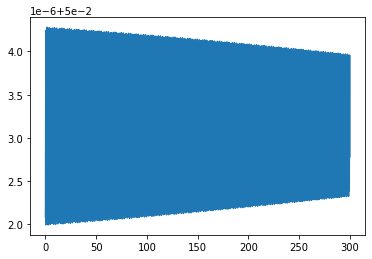

In [9]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])

In [15]:
unit_r = np.empty(3) 
newR = np.empty(3)

nu = E_to_nu(M_to_E(np.array([belt.M.to(u.rad).value]).T, belt.ecc.value, numpyOutput=True), belt.ecc.value, numpyOutput=True)

positions, velocities = PA.core.elements.coe2rv_many(np.full(belt.size, belt.micro)*u.km**3/u.s**2, (belt.a*(1-np.square(belt.ecc))).to("km").value, belt.ecc.value, belt.inc.to("rad").value, belt.Omega.to("rad").value, belt.w.to("rad").value, nu.to("rad").value)

kickStrength = 0.001*u.km

old_radius = np.linalg.norm(positions, axis=1)
unit_r = positions/old_radius
old_r_0 = belt.a*(1 - np.square(belt.ecc))
newPosition = radiuses + kickStrength*unit_r
oldThetaVelocity = velocities - np.einsum("ik,ik->i", velocities, unit_r)*unit_r
newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
newVelocity = np.einsum("ik,ik->i", velocities, unit_r)*unit_r + newThetaVelocity
p, belt.ecc, belt.inc, belt.Omega, belt.w, nu = PA.core.elements.rv2coe(belt.micro, newPosition, newVelocity)
belt.a = p/(1 - np.square(belt.ecc))
belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(nu, belt.ecc), belt.ecc)*u.rad
new_r_0 = belt.a*(1 - np.square(belt.ecc))
if old_r_0 - new_r_0 > 10**-12*u.km:
    print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)

M's shape is  (20000, 1) . e's shape is  (20000,)


UnitConversionError: 'km3 / s2' and '' (dimensionless) are not convertible

In [41]:
gpuStart = time_pkg.time()
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, quad_time-dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  19  memory frames
GPU Time:  35.86150240898132  Astro Time:  0.0015015602111816406


In [42]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

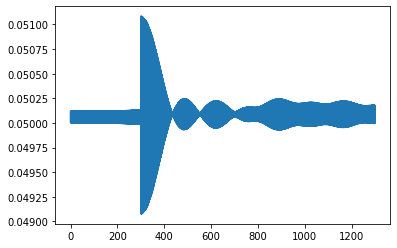

In [43]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])

In [44]:
unit_r = np.empty(3) 
newR = np.empty(3)

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

quad_strength = 0.35 * u.second**-1
radius_offset = r_0

for i in range(0, belt.size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
        orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [45]:
gpuStart = time_pkg.time()
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, end_time - quad_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  25  memory frames
GPU Time:  66.70010781288147  Astro Time:  0.005867481231689453


In [46]:
avr_radius[quad_step:end_step] = average_scaler(radiuses[quad_step:end_step], start=quad_step, end=end_step)

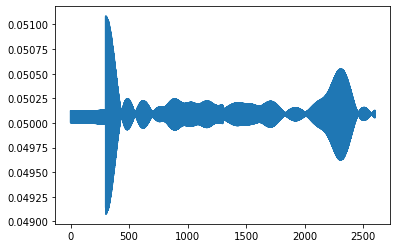

In [47]:
plt.plot(time[0:end_step], avr_radius[0:end_step])